In [ ]:
#Install Scikit-Learn

#!pip install scikit-learn

In [ ]:
#Install pySpark

#!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=4ebf5e3f10c4daa8c6b75117cddc40b970e3888d2594b14e899e6c8fba3e162d
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
#Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from google.cloud import storage

#Authenticate User
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

# Initialize a GCS client
storage_client = storage.Client()

# Define bucket and file paths
landing_folder_name = 'trusted'
input_file_name = 'tested nypd_mv_collisions'
output_folder_name = 'models'
output_file_name = 'models nypd_mv_collisions'

# Read data from the landing folder file
landing_bucket = storage_client.bucket('my-project-bucket-bc')
landing_blob = landing_bucket.blob(f'{landing_folder_name}/{input_file_name}')
local_file_path = '/tmp/input_file.csv'
landing_blob.download_to_filename(local_file_path)

Authenticated


In [ ]:
df = pd.read_parquet(local_file_path)

In [ ]:
import os

os.environ["HADOOP_CONF_DIR"] = "/usr/local/lib/python3.10/dist-packages/pyspark"

from pyspark.sql import SparkSession

# Initialize SparkSession with additional libraries for GCS support
spark = SparkSession.builder \
    .appName("NYPD Collisions Analysis") \
    .config("spark.hadoop.fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem") \
    .config("spark.hadoop.fs.gs.project.id", "my-project-bucket-bc") \
    .config("spark.hadoop.fs.gs.auth.service.account.enable", "true") \
    .config("spark.hadoop.google.cloud.auth.service.account.json.keyfile", "cis-4130-semester-project-18c39c58bea4.json") \
    .config("spark.hadoop.fs.gs.auth.service.account.json.keyfile", "cis-4130-semester-project-18c39c58bea4.json") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

In [ ]:
spark_df = spark.createDataFrame(df)

In [ ]:
spark_df.printSchema()

root
 |-- borough: string (nullable = true)
 |-- contributing_factor_vehicle_1: string (nullable = true)
 |-- contributing_factor_vehicle_2: string (nullable = true)
 |-- contributing_factor_vehicle_3: string (nullable = true)
 |-- contributing_factor_vehicle_4: string (nullable = true)
 |-- contributing_factor_vehicle_5: string (nullable = true)
 |-- cross_street_name: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- number_of_cyclist_injured: long (nullable = true)
 |-- number_of_cyclist_killed: long (nullable = true)
 |-- number_of_motorist_injured: long (nullable = true)
 |-- number_of_motorist_killed: long (nullable = true)
 |-- number_of_pedestrians_injured: long (nullable = true)
 |-- number_of_pedestrians_killed: long (nullable = true)
 |-- number_of_persons_injured: long (nullable = true)
 |-- number_of_persons_killed: long (nullable = true)
 |-- unique_key: long (nullable = true)
 |-- vehicle_type_code1: string (nullable = true)
 |-- vehicle_type_code2: 

In [ ]:
# Import some modules needed later on
from pyspark.sql.functions import col, isnan, when, count, udf, to_date, year, month, date_format, size, split
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import to_timestamp

# Convert the timestamp column to an actual timestamp data type, and the other format of time
spark_df = spark_df.withColumn('timestamp', to_timestamp(spark_df.timestamp, 'yyyy-MM-dd HH:mm:ss'))
spark_df = spark_df.withColumn("time_year", year("timestamp"))
spark_df = spark_df.withColumn("time_month", month("timestamp"))
spark_df = spark_df.withColumn("time_yearmonth", date_format("timestamp", "yyyy-MM"))
spark_df = spark_df.withColumn("time_dayofweek", date_format("timestamp", "E"))
spark_df = spark_df.withColumn("time_weekend", when(spark_df.time_dayofweek == 'Saturday', 1.0)
                               .when(spark_df.time_dayofweek == 'Sunday', 1.0)
                               .otherwise(0))

In [ ]:
spark_df.show()

+---------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+--------------------+-------------------+-------------------------+------------------------+--------------------------+-------------------------+-----------------------------+----------------------------+-------------------------+------------------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+----------+--------------+--------------+------------+
|  borough|contributing_factor_vehicle_1|contributing_factor_vehicle_2|contributing_factor_vehicle_3|contributing_factor_vehicle_4|contributing_factor_vehicle_5|   cross_street_name|          timestamp|number_of_cyclist_injured|number_of_cyclist_killed|number_of_motorist_injured|number_of_motorist_killed|number_of_pedestrians_injured|number_of_pedestrians_killed|number_of_persons_injured|number_of_pe

Text(0.5, 1.0, 'Total of People Injured vs. Years')

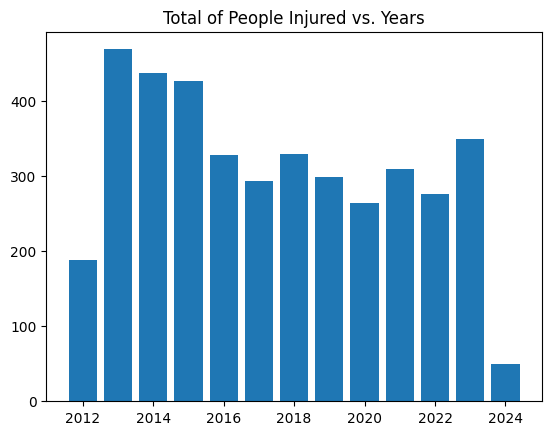

In [ ]:
sparks_df_TPI = spark_df.groupby('time_year').sum("number_of_persons_injured").toPandas()
sparks_df_TPI
# Set up a Matplotlib figure
fig = plt.figure(facecolor='white')
# Bar Plot of borough and count
plt.bar(sparks_df_TPI['time_year'],sparks_df_TPI['sum(number_of_persons_injured)'] )
# Add a title
plt.title("Total of People Injured vs. Years")

In [ ]:
# Set "time_year" column as the index
sparks_df_TPI.set_index("time_year", inplace=True)

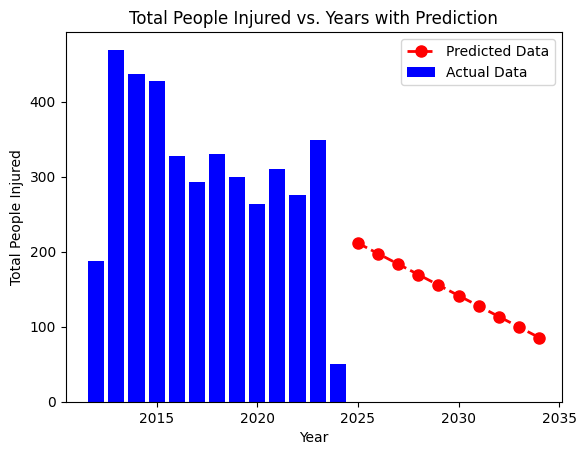

   Year  Predicted_People_Injured
0  2025                211.346154
1  2026                197.362637
2  2027                183.379121
3  2028                169.395604
4  2029                155.412088
5  2030                141.428571
6  2031                127.445055
7  2032                113.461538
8  2033                 99.478022
9  2034                 85.494505


In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Prepare the data for linear regression
X = sparks_df_TPI.index.values.reshape(-1, 1)  # Assuming the index represents the years
y = sparks_df_TPI['sum(number_of_persons_injured)'].values

# Create and train the linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict future values (e.g., next 5 years)
future_years = np.array([sparks_df_TPI.index.max() + i for i in range(1, 11)]).reshape(-1, 1)
predictions = model.predict(future_years)

# Plot the original data and the prediction
plt.figure(facecolor='white')

# Plot original data
plt.bar(sparks_df_TPI.index, sparks_df_TPI['sum(number_of_persons_injured)'], color='blue', label='Actual Data')

# Plot predictions
plt.plot(future_years, predictions, color='red', marker='o', linestyle='dashed', linewidth=2, markersize=8, label='Predicted Data')

# Add titles and labels
plt.title("Total People Injured vs. Years with Prediction")
plt.xlabel("Year")
plt.ylabel("Total People Injured")
plt.legend()

plt.show()

# Display the predicted values
predicted_df = pd.DataFrame({"Year": future_years.flatten(), "Predicted_People_Injured": predictions})
print(predicted_df)


In [ ]:
# Save the plot to Google Cloud Storage
import io
from google.cloud import storage

In [ ]:
# Create a buffer to hold the figure
img_data = io.BytesIO()
# Write the figure to the img_data buffer
fig.get_figure().savefig(img_data, format='png', bbox_inches='tight')
# Rewind the pointer to the start of the data
img_data.seek(0)

# Connect to Google Cloud Storage
storage_client = storage.Client()
# Point to the bucket on Google Cloud Storage (change this to match the name of your bucket)
bucket = storage_client.get_bucket('my-project-bucket-bc')

folder_path = 'models'
file_name = "Total People Injured vs. Years with Prediction.png"
# Create a blob to hold the data. Give it a file name with the folder path included
blob = bucket.blob(f'{folder_path}/{file_name}')

# Upload the img_data contents to the blob
blob.upload_from_file(img_data)

Text(0.5, 1.0, 'Total of People Injured vs. Month')

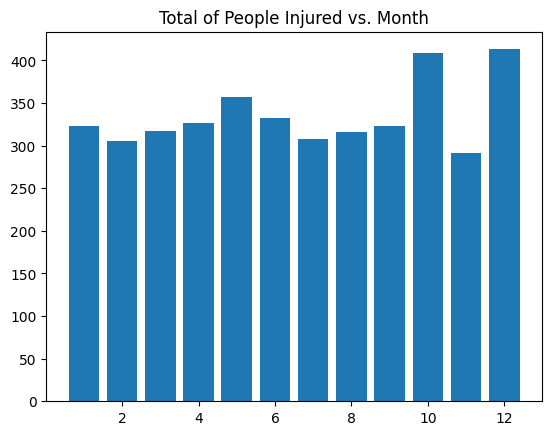

In [ ]:
sparks_df_TMPI = spark_df.groupby('time_month').sum("number_of_persons_injured").toPandas()
sparks_df_TMPI
# Set up a Matplotlib figure
fig = plt.figure(facecolor='white')
# Bar Plot of borough and count
plt.bar(sparks_df_TMPI['time_month'],sparks_df_TMPI['sum(number_of_persons_injured)'] )
# Add a title
plt.title("Total of People Injured vs. Month")